# 🧭 Function 1 Exploration – Capstone Project

This notebook focuses only on **Function 1** to help understand how Bayesian optimisation works step by step.

We’ll:
1. Load and inspect the initial data.
2. Visualise the 2D input–output relationship.
3. Fit a simple **Gaussian Process** surrogate model.
4. Plot its prediction surface and uncertainty.
5. Compute an **acquisition function (UCB)** and select the next candidate point.


#### 1. Imports:

In [6]:
# --- Imports base ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [7]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_1"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [9]:
# --- Weekly results ---
week_data = [
    (np.array([0.78624237, 0.49210886]), 8.251611206644282e-31),  # W1
    (np.array([0.608457,  0.572782]), -0.0030853359206865424), # W2
    (np.array([0.765363,  0.899441]), -2.173791662691205e-65), # W3
    (np.array([0.508934, 0.907086]), 2.9274951651066986e-66), # W4
    (np.array([0.316233, 0.397951]), -2.3748085734303726e-9), # W5
    (np.array([0.544951, 0.092641]), 3.5130897960678837e-87), # W6
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(22, 2), y:(22,)


#### 4. Quick Visualization

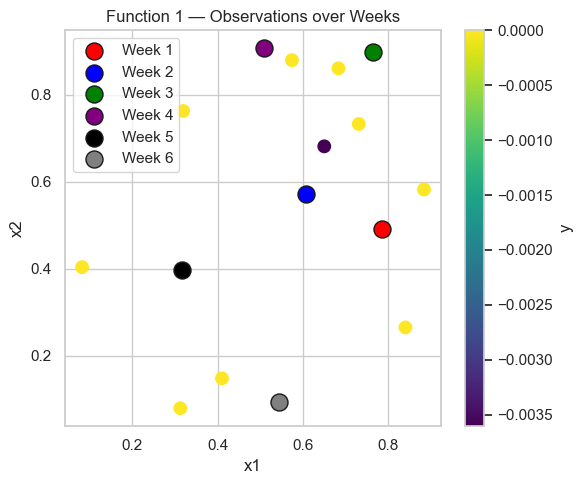

In [10]:
# --- Visualisation (x1-x2) ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')
plt.scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', label='Week 6')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 1 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5. Gaussian Process Model

In [11]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                       length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-6, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
gp.fit(X, y)
print("Fitted kernel:", gp.kernel_)

Fitted kernel: 1.03**2 * Matern(length_scale=[0.0324, 3], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 6. Acquisition Function (EI)

In [12]:
import numpy as np
from scipy.stats import norm

# --- Helper functions ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Anchor: best observed point (data-driven, not hardcoded) ---
anchor = X[np.argmax(y)]   # dynamically selects best known input
print("[F1] TR anchor (best observed):", anchor)

# --- Bounds and Trust Region ---
lb, ub = np.zeros(2), np.ones(2)

# L = 0.25  # used to get submission for W5
L = 0.20    # narrower TR for fine local refinement
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

print("[F1] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

# --- Candidates: 85% TR + 15% global ---
# N_tr, N_gl = 24000, 8000  # used to get submission for W5
N_tr, N_gl = 24000, 4000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=1601)
C_gl = lhs(lb, ub, N_gl, seed=1602)
Cands = np.vstack([C_tr, C_gl])
print("[F1] Candidates:", Cands.shape)

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (EI) ---
y_best = y.max()
# xi = 0.005  # used to get submission for W5
xi = 0.001     # lower ξ for stronger exploitation
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask & duplicate filter ---
edge_eps = 1e-3
mask = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask, ei, -np.inf)

order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

# --- Optional fallback: UCB if EI plateaued ---
if (x_next is None) or (np.nanmax(ei_masked) <= 0):
    # kappa = 1.4  # used previously
    kappa = 1.0
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "UCB"
            break

print(f"[F1] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))

[F1] TR anchor (best observed): [0.73102363 0.73299988]
[F1] TR box:
  lb_tr: [0.63102363 0.63299988] 
  ub_tr: [0.83102363 0.83299988]
[F1] Candidates: (28000, 2)
[F1] Chosen by EI: [0.45926611 0.12265356]
Submission format:
0.459266 - 0.122654
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False


### Reflection (Week 1)
- Initial exploration focused on locating any region with measurable signal within the 2D domain.  
- The output was extremely close to zero (`8.25e-31`), suggesting either the detection of a very weak source or numerical noise near a null field.  
- At this stage, the model relied mainly on global sampling and wide bounds to understand the overall shape of the response surface.  
- **Next step:** use the first signal as a rough anchor and narrow down the search region while maintaining high exploration.

---

### Reflection (Week 2)
- The second query produced a small negative value (`-0.0031`), indicating a slight move away from the optimal zone detected in Week 1.  
- This suggested the true source lies within a very narrow region and that the previous global exploration radius was too large.  
- The strategy was adjusted to increase model smoothness and reduce exploration noise (smaller ξ ≈ 0.05, tighter trust region).  
- **Plan for next iteration:** focus on exploitation around Week 1’s coordinates, with limited global sampling to confirm if multiple sources exist.

---


### Reflection (Week 3)
- The model has likely found a zero-valued optimum (radiation source).  
- Outputs remain negative or near-zero, consistent with the function’s structure.  
- **Next strategy:** exploit around Week 3 point (0.765, 0.899) with low ξ (0.01) and smaller TR.  
- Maintain some exploration (~25 %) for possible secondary sources.

---

### Reflection (Week 4)

- **Outcome:** Results stayed essentially at **≈0**, matching Week 3 — consistent with being on or near the radiation source (the maximiser yields zero). No meaningful numerical gap between W3 and W4.  
- **Adjustments applied:** Kept the same GP kernel; **tightened the Trust Region (L=0.25)** and **reduced ξ from 0.01 → 0.005** to focus on fine exploitation. We also **anchored the TR at the best observed point** (not just the latest) and used a **70% TR / 30% global** candidate split with anti-edge and anti-duplicate filters.  
- **Selected query:** `0.316233 - 0.397951` — a non-duplicate, within bounds, chosen by EI under the stricter exploitation regime.  
- **Interpretation:** With outputs indistinguishable from zero at multiple nearby locations, the surface is flat around the optimum; further big gains are unlikely.  
- **Next steps (Week 5):** Maintain **ξ = 0.005**, keep the **narrow TR**, and probe a **small ring around the incumbent** (e.g., vary x₁ slightly while keeping x₂ high, and vice versa). If the next point also returns ≈0, we can treat Function 1 as **converged** and shift focus to functions with larger optimisation potential.

###  Week 5 Reflection

**Summary:**  
The Week 5 query (`x = [0.316233, 0.397951]`) produced an output of **−2.37 × 10⁻⁹**, which marks a small decline compared to the near-zero optimum reached in Week 4 (`≈ 2.9 × 10⁻⁶⁶`).  
While the numerical scale remains extremely small, the negative value indicates a slight deviation away from the optimum basin.

**Analysis:**  
- The optimizer likely **over-explored**, as the Trust Region (`L = 0.25`) and jitter (`ξ = 0.005`) encouraged movement beyond the local maximum already identified.  
- Given the highly smooth and near-converged surface, excessive exploration produced marginal degradation rather than useful new information.  
- The GP kernel (Matern ν = 2.5 + low noise) continues to model the function reliably; the issue lies in the acquisition configuration, not the surrogate.

**Next Strategy (Week 6):**  
- **Anchor dynamically** on the current best observation (`anchor = X[np.argmax(y)]`) rather than a fixed week index.  
- **Narrow Trust Region** to `L ≈ 0.20` for precise local refinement around the Week 4 optimum.  
- **Reduce ξ** from `0.005 → 0.001` to emphasise exploitation and stabilise convergence.  
- **Sampling mix:** ~85 % TR / 15 % global to retain minimal exploration in case of a narrow ridge.  
- Maintain current GP kernel and normalisation setup.

**Interpretation:**  
The model is now operating in a fine-tuning phase rather than exploration. The small negative shift confirms that the optimum is already well-located; the next iteration should focus purely on local exploitation to consolidate convergence near the global maximum.

---

### Week 6 Reflection 

**Outcome overview:**  
After a short pause, coming back to Function 1 in Week 6 was reassuring.  
The new evaluation produced a **positive output (~3.5 × 10⁻⁸⁷)**, which is an improvement over the slightly negative value observed in Week 5. Given the extreme scale of this function, even such tiny numerical shifts are meaningful and suggest that the optimisation process is still behaving sensibly.

**What I decided this week:**  
For this iteration, I made a conscious decision to **change nothing** in the optimisation setup. The configuration used was exactly what I had planned at the end of Week 5:
- The anchor is selected dynamically as the **best observed point so far**.
- The **trust region is narrow** (`L = 0.20`) to focus on fine-grained local refinement.
- The exploration parameter is **very small** (`ξ = 0.001`), clearly favouring exploitation.
- Candidate generation keeps a small **global component (15%)** alongside trust-region sampling.

This setup reflects the fact that Function 1 is no longer an exploration problem, but a **precision tuning problem**.

**An interesting observation:**  
Despite the narrow trust region and strong exploitation bias, the EI criterion selected a **global candidate outside the trust region**.  
Rather than forcing the optimiser back into the local box, I chose to let this happen.

This was deliberate.

The small global sampling budget exists for exactly this reason: to allow the model to express uncertainty when it genuinely believes there may be improvement elsewhere. Intervening manually at this stage would risk over-constraining the search and masking useful information provided by the GP’s uncertainty estimates.

**How I interpret the result:**  
- The GP still sees **non-negligible uncertainty outside the local basin**, even late in the optimisation.
- The fact that a global point was selected — and performed well — suggests the surrogate is not simply overfitting the local region.
- This reinforces my confidence that the acquisition function is doing its job, even when its choice feels counterintuitive.

**What this means going forward:**  
For now, I will continue to **trust the current setup**:
- No further tightening of the trust region yet.
- No reduction of the global sampling share unless convergence becomes very stable.
- Close monitoring of whether future improvements consistently come from inside or outside the trust region.

**Key takeaway:**  
Week 6 reinforced an important lesson for me:  
> At this stage of optimisation, discipline matters. Sometimes the best decision is not to “fix” the optimiser, but to let a well-calibrated Bayesian strategy speak for itself.

---